#Secondary structure prediction

## Set up

In [ ]:
import os

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

!pip install -q biopython transformers datasets huggingface_hub accelerate
!pip install lightgbm

import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

In [ ]:
#@title Select a model
#@markdown ---
model_name = '500M_human_ref'#@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species', '50M_multi_species_v2', '100M_multi_species_v2', '250M_multi_species_v2', '500M_multi_species_v2']
#@markdown ---

##Import model

In [ ]:
embeddings_layer = 20  # layer of embeddings extraction (0:24)
seq_max_length = 200  # Max length of the protein sequence

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    embeddings_layers_to_save=(embeddings_layer,),
    max_positions= 999  # maximum number of tokens per sequence
)
forward_fn = hk.transform(forward_fn)

##Import dataset and preprocessing

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset_dict = load_dataset("proteinea/secondary_structure_prediction")
dataset = dataset_dict["train"].to_pandas()

def filter_dataset(dataset, seq_max_length):
    # making subsequences of length 100
    filtered_rows = []

    for index, row in dataset.iterrows():
        input_string = row["input"]
        dssp3_string = row["dssp3"]
        dssp8_string = row["dssp8"]

        x_positions = [pos for pos, char in enumerate(input_string) if char == 'X']
        o_positions = [pos for pos, char in enumerate(input_string) if char == 'O']

        if not (x_positions or o_positions):
            if len(input_string) <= seq_max_length:
                filtered_rows.append(row)
            else:
                n = int(len(input_string)/seq_max_length) # Number of substrings created
                for i in range(n):
                    start = i * seq_max_length
                    stop = start + seq_max_length

                    new_row = {
                        "input": input_string[start:stop],
                        "dssp3": dssp3_string[start:stop],
                        "dssp8": dssp8_string[start:stop]
                    }

                    filtered_rows.append(new_row)
        else:
            occurrences = sorted(x_positions + o_positions)

            start_idx = 0  # First non "X" or "O"
            for i in occurrences:
                if i - start_idx >= 100:
                    new_row = {
                        "input": input_string[start_idx:i],
                        "dssp3": dssp3_string[start_idx:i],
                        "dssp8": dssp8_string[start_idx:i]
                    }
                    filtered_rows.append(new_row)
                start_idx = i + 1

            # Check for the remaining substring at the end of the input string
            if len(input_string) - start_idx >= 100:
                new_row = {
                    "input": input_string[start_idx:],
                    "dssp3": dssp3_string[start_idx:],
                    "dssp8": dssp8_string[start_idx:]
                }
                filtered_rows.append(new_row)

    df = pd.concat([pd.DataFrame([row]) for row in filtered_rows], ignore_index=True)
    return df

df = filter_dataset(dataset)
df = df[:3000]  # Adjust to available memory


X_proteins = df["input"]
y_seq = df["dssp8"]  # Can be changed to "dssp8"

## Making amino acid sequences into dna sequences

In [ ]:
import random

def protein_to_rna(protein_sequence):
    amino_acid_to_codons = {
        "A": ["GCU", "GCC", "GCA", "GCG"],
        "R": ["CGU", "CGC", "CGA", "CGG", "AGA", "AGG"],
        "N": ["AAU", "AAC"],
        "D": ["GAU", "GAC"],
        "B": ["AAU", "AAC", "GAU", "GAC"],
        "C": ["UGU", "UGC"],
        "Q": ["CAA", "CAG"],
        "E": ["GAA", "GAG"],
        "Z": ["CAA", "CAG", "GAA", "GAG"],
        "G": ["GGU", "GGC", "GGA", "GGG"],
        "H": ["CAU", "CAC"],
        "I": ["AUU", "AUC", "AUA"],
        "L": ["CUU", "CUC", "CUA", "CUG", "UUA", "UUG"],
        "K": ["AAA", "AAG"],
        "M": ["AUG"],
        "F": ["UUU", "UUC"],
        "P": ["CCU", "CCC", "CCA", "CCG"],
        "S": ["UCU", "UCC", "UCA", "UCG", "AGU", "AGC"],
        "T": ["ACU", "ACC", "ACA", "ACG"],
        "W": ["UGG"],
        "Y": ["UAU", "UAC"],
        "V": ["GUU", "GUC", "GUA", "GUG"],
        "U": ["UUU"], # Approximation used to maintain the sequence token class structure
    }

    # Converts protein sequence to RNA sequence
    rna_sequence = ''
    for amino_acid in protein_sequence:
        codons = amino_acid_to_codons.get(amino_acid)
        rna_sequence += codons[random.randint(0, len(codons)-1)]  # Chose codon

    return rna_sequence

X_rna = [protein_to_rna(protein) for protein in X_proteins]

In [ ]:
def rna_to_dna(rna_sequence):
    rna_to_dna_base_pairs = {'A': 'T', 'U': 'A', 'C': 'G', 'G': 'C'}

    # Convert RNA sequence to complementary DNA sequence
    dna_sequence = ''.join(rna_to_dna_base_pairs.get(base) for base in rna_sequence)

    return dna_sequence

X_dna = [rna_to_dna(rna_sequence) for rna_sequence in X_rna]

##Tokenizing and retrieving embeddings

In [ ]:
batch_size = 8 # Adjust to available memory

def get_6mers_embeddings(sequences: list, batch_size: int):
    embeddings = []  # Stores 6mers embeddings

    # Split sequences into batches
    batched_sequences = [sequences[i:i + batch_size] for i in range(0, len(sequences), batch_size)]

    random_key = jax.random.PRNGKey(0)
    extraction_layer = "embeddings_" + str(embeddings_layer)
    cls_token_position = 0 # Position of the CLS token for every sequence

    for batch in batched_sequences:
        # Tokenize the batch
        tokens_ids = [b[1] for b in tokenizer.batch_tokenize(batch)]
        tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

        # Infer
        outs = forward_fn.apply(parameters, random_key, tokens)

        # Get embeddings
        batch_embeddings = outs[extraction_layer]

        # Mask for padding tokens
        padding_mask = (tokens != tokenizer.pad_token_id) & (jnp.arange(tokens.shape[1]) != cls_token_position)

        # Element-wise multiplication to set embeddings corresponding to padding tokens to zero
        masked_embeddings = batch_embeddings * padding_mask[:, :, None]

        # Removing embeddings relative to CLS and padding tokens
        sum_embeddings = jnp.sum(masked_embeddings, axis=-1)
        non_zero_mask = sum_embeddings != 0.0
        non_zero_embeddings = masked_embeddings[non_zero_mask]

        embeddings.append(non_zero_embeddings)


    return jnp.concatenate(embeddings, axis=0)

In [ ]:
X = get_6mers_embeddings(X_dna, batch_size)

In [ ]:
conc_y = ''  # Concatenated sequences of target dna
conc_y = conc_y.join(y_seq)

y = [conc_y[i] + conc_y[i+1] for i in range(0, len(conc_y), 2)]  # Cartesian product of classes

## Downstream task

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

params = {
    'objective': 'multiclass',  # 'multiclass' for multi-class classification
    'metric': 'multi_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

clf = lgb.LGBMClassifier(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

def cartesian_accuracy_score(y_pred, y_test):
    y_pred = [char for string in y_pred for char in string]
    y_test = [char for string in y_test for char in string]
    return accuracy_score(y_test, y_pred)

# Evaluate the classifier's performance
accuracy = cartesian_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 10.404520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 243527, number of used features: 1280
[LightGBM] [Info] Start training from score -1.074221
[LightGBM] [Info] Start training from score -3.117442
[LightGBM] [Info] Start training from score -3.375124
[LightGBM] [Info] Start training from score -3.137019
[LightGBM] [Info] Start training from score -1.769872
[LightGBM] [Info] Start training from score -5.941515
[LightGBM] [Info] Start training from score -3.359524
[LightGBM] [Info] Start training from score -6.516879
[LightGBM] [Info] Start t

## Prediction confusion matrix

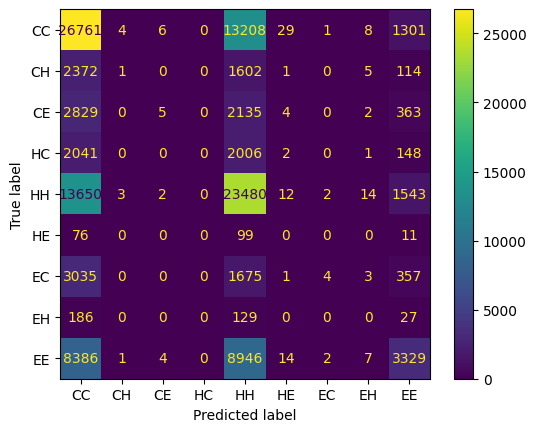

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels= ["CC", "CH", "CE", "HC", "HH", "HE", "EC", "EH", "EE"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CC", "CH", "CE", "HC", "HH", "HE", "EC", "EH", "EE"])
disp.plot()
plt.show()

## Testing model on training data

In [ ]:
train_pred = clf.predict(X_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


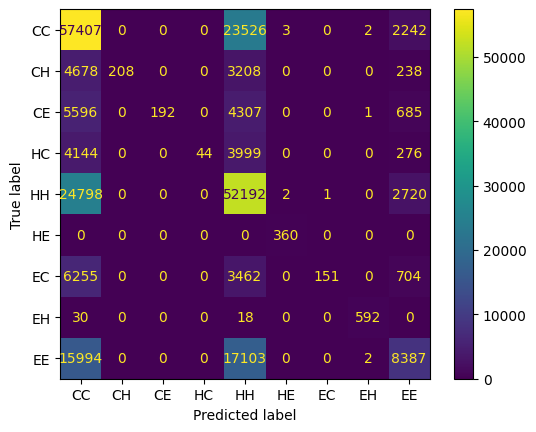

In [ ]:
cm2 = confusion_matrix(y_train, train_pred, labels= ["CC", "CH", "CE", "HC", "HH", "HE", "EC", "EH", "EE"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["CC", "CH", "CE", "HC", "HH", "HE", "EC", "EH", "EE"])
disp.plot()
plt.show()

In [ ]:
# Evaluate the classifier's performance
accuracy = cartesian_accuracy_score(y_train, train_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.55
